# Natural Language Processing Project



This project uses data downloaded from Kaggle containing all NIPS papers between 1987 and 2016. https://www.kaggle.com/benhamner/nips-papers

The Neural Information Processing Systems (NIPS) conference is one of the most important events in Machine Learning. It receives hundreds of papers from researchers all over the world each year. 

In [2]:
# Import Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis.sklearn

import warnings
warnings.simplefilter("ignore", DeprecationWarning)


In [3]:
# Import dataset
papers=pd.read_csv('papers.csv')

In [4]:
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [5]:
# Metadata not required for project so removed

papers.drop(['id', 'event_type', 'pdf_name'], axis=1, inplace=True)

In [6]:
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [7]:
#  EDA and visualization

In [10]:
s=papers.year.value_counts()

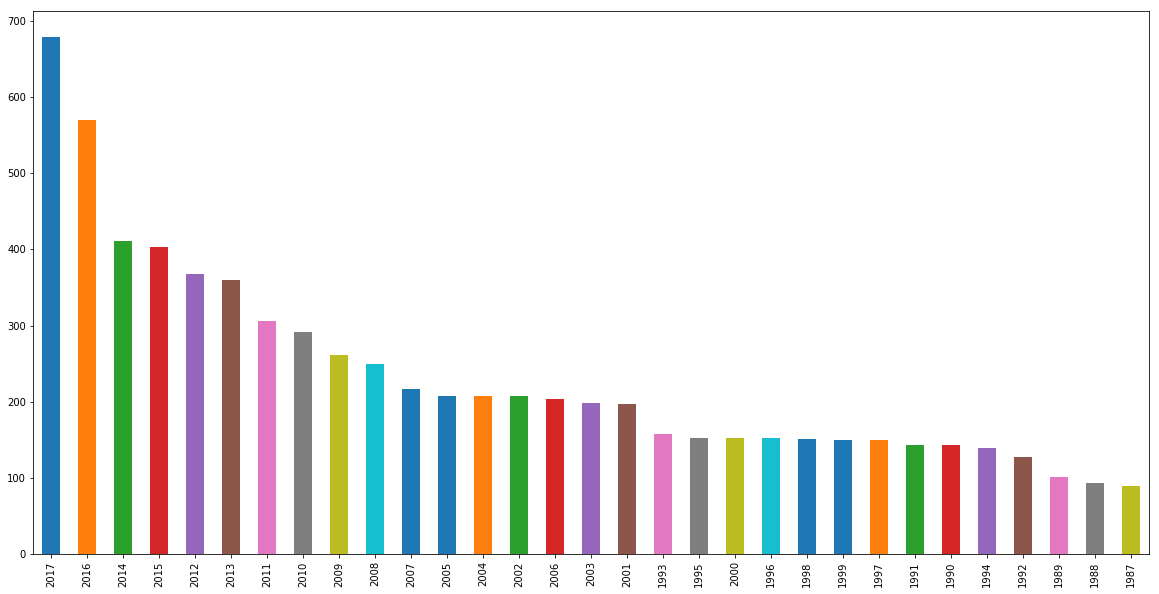

In [11]:
plt.figure(figsize=(20,10)) 
s.plot.bar()

In [49]:
# Pre-processing text

In [50]:
papers.title.head()

0    Self-Organization of Associative Database and ...
1    A Mean Field Theory of Layer IV of Visual Cort...
2    Storing Covariance by the Associative Long-Ter...
3    Bayesian Query Construction for Neural Network...
4    Neural Network Ensembles, Cross Validation, an...
Name: title, dtype: object

In [51]:
# remove punctuation in text and cenvert to lower case
papers['title_processed'] = papers['title'].map(lambda x: re.sub('[,\.!?]', '', x))

In [52]:
papers['title_processed']=[x.lower() for x in papers.title_processed]

In [53]:
papers.title_processed.head()

0    self-organization of associative database and ...
1    a mean field theory of layer iv of visual cort...
2    storing covariance by the associative long-ter...
3    bayesian query construction for neural network...
4    neural network ensembles cross validation and ...
Name: title_processed, dtype: object

In [54]:
papers.head()

,year,title,abstract,paper_text,title_processed
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,self-organization of associative database and ...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,a mean field theory of layer iv of visual cort...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,storing covariance by the associative long-ter...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,bayesian query construction for neural network...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...",neural network ensembles cross validation and ...


In [64]:
# WordCloud
space=' ';
seq=papers.title_processed
long_string=space.join(seq)
long_string[0:100]

'self-organization of associative database and its applications a mean field theory of layer iv of vi'

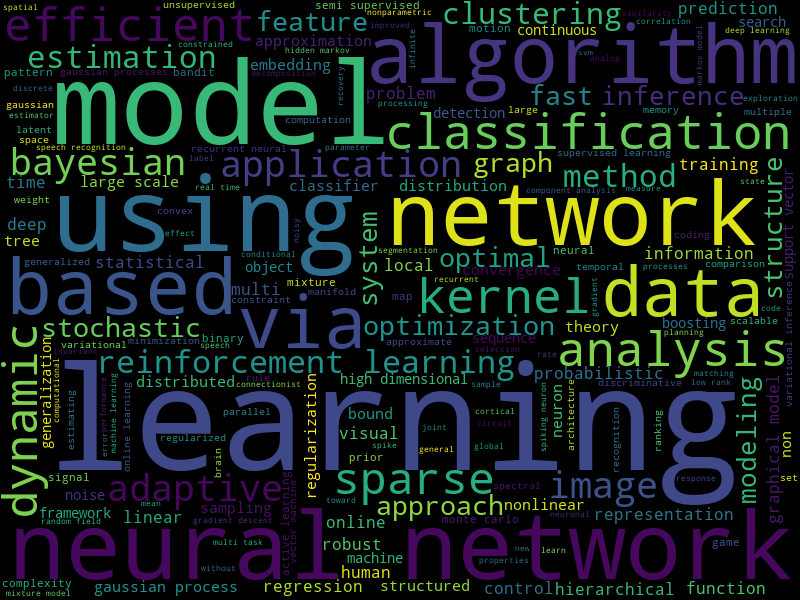

In [75]:
wordcloud=WordCloud(width=800, height=600).generate(str(long_string))
wordcloud.to_image()

https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

The main text analysis method that we will use is latent Dirichlet allocation (LDA). LDA is able to perform topic detection on large document sets, determining what the main 'topics' are in a large unlabeled set of texts. A 'topic' is a collection of words that tend to co-occur often. The hypothesis is that LDA might be able to clarify what the different topics in the research titles are. These topics can then be used as a starting point for further analysis.

LDA does not work directly on text data. First, it is necessary to convert the documents into a simple vector representation. This representation will then be used by LDA to determine the topics. Each entry of a 'document vector' will correspond with the number of times a word occurred in the document. In conclusion, we will convert a list of titles into a list of vectors, all with length equal to the vocabulary. For example, 'Analyzing machine learning trends with neural networks.' would be transformed into [1, 0, 1, ..., 1, 0].

We'll then plot the 10 most common words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

In [77]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()

In [79]:
# Initialize count vectorizer and fit transform processed titles
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(papers['title_processed'])

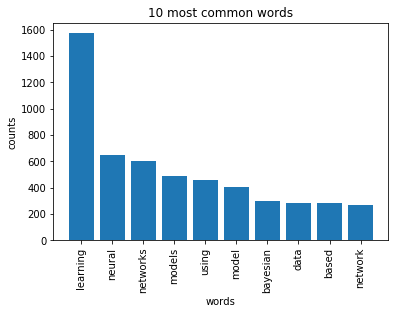

In [80]:
plot_10_most_common_words(count_data, count_vectorizer)

In [85]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        

In [94]:
number_topics = 5
number_words = 5

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit_transform(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
visual image using hierarchical search

Topic #1:
learning multi models stochastic linear

Topic #2:
analysis estimation information fast classification

Topic #3:
neural networks learning network using

Topic #4:
gaussian clustering regression processes process


In [95]:
# Topic frequencies
x=lda.transform(count_vectorizer.transform([long_string]))

In [96]:
print(x, x.sum())

[[0.131447   0.27113376 0.18765941 0.26268211 0.14707771]] 1.0


In [ ]:
# LDA results visualization

In [100]:
pyLDAvis.enable_notebook()

In [101]:
panel = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer, mds='tsne')
panel


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      25.939012        1       1 -131.342697 -121.960442
3      25.288170        1       2   76.527397 -161.796280
2      18.971282        1       3   84.806732  -34.784210
4      15.544422        1       4  -38.026356  -41.777069
0      14.257113        1       5  -37.248089 -207.673553, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
3199  Default   591.000000          neural   591.000000  30.0000  30.0000
3198  Default   552.000000        networks   552.000000  29.0000  29.0000
183   Default   217.000000        analysis   217.000000  28.0000  28.0000
1959  Default   191.000000        gaussian   191.000000  27.0000  27.0000
3196  Default   239.000000         network   239.000000  26.0000  26.0000
792   Default   164.000000      clustering   164.000000  25.0000  25.0000
1658  Default   183.000000      estimation   183.000000  24.0000  24.0000
2631  Default  1405.000000        learning  1405.000000  23.0000  23.0000
3101  Default   209.000000           multi   209.000000  22.0000  22.0000
4048  Default   146.000000      regression   146.000000  21.0000  21.0000
5298  Default   137.000000          visual   137.000000  20.0000  20.0000
2251  Default   134.000000           image   134.000000  19.0000  19.0000
1226  Default   188.000000            deep   188.000000  18.0000  18.0000
4713  Default   186.000000      stochastic   186.000000  17.0000  17.0000
2353  Default   146.000000     information   146.000000  16.0000  16.0000
2692  Default   177.000000          linear   177.000000  15.0000  15.0000
3793  Default   120.000000       processes   120.000000  14.0000  14.0000
1795  Default   134.000000            fast   134.000000  13.0000  13.0000
3792  Default   118.000000         process   118.000000  12.0000  12.0000
1517  Default   163.000000       efficient   163.000000  11.0000  11.0000
5228  Default   393.000000           using   393.000000  10.0000  10.0000
137   Default   156.000000      algorithms   156.000000   9.0000   9.0000
768   Default   178.000000  classification   178.000000   8.0000   8.0000
3924  Default   103.000000          random   103.000000   7.0000   7.0000
3374  Default   206.000000    optimization   206.000000   6.0000   6.0000
3346  Default   142.000000          online   142.000000   5.0000   5.0000
4065  Default   139.000000   reinforcement   139.000000   4.0000   4.0000
2138  Default    93.000000    hierarchical    93.000000   3.0000   3.0000
2143  Default    96.000000            high    96.000000   2.0000   2.0000
3033  Default   437.000000          models   437.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
2828   Topic5    47.121814             map    47.844885   1.9327  -4.9102
3794   Topic5    42.907496      processing    43.624016   1.9314  -5.0039
3942   Topic5    42.387581           rates    43.111627   1.9310  -5.0161
1398   Topic5    42.165927  discriminative    42.886969   1.9310  -5.0214
1657   Topic5    40.150161      estimating    40.873704   1.9301  -5.0703
4412   Topic5    36.150657        sequence    36.869654   1.9282  -5.1753
429    Topic5    34.267291           bayes    34.989638   1.9271  -5.2288
3218   Topic5    33.940900        neuronal    34.661766   1.9269  -5.2383
1097   Topic5    33.482970          cortex    34.202470   1.9267  -5.2519
3217   Topic5    31.967141          neuron    32.685435   1.9257  -5.2983
2344   Topic5    31.010251        infinite    31.732794   1.9249  -5.3286
1806   Topic5    28.925026        feedback    29.646254   1.9233  -5.3983
4167   Topic5    27.531698        response    28.252444   1.9221  -5.4476
341    Topic5    26.308172        auditory    27.024482   1.9211  -5.4931
2503   Topic5    25.771430       iteration    26.492623   1.9203  -5.5137

In [89]:
tvec = TfidfVectorizer(stop_words='english')
tvec.fit([long_string])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [92]:
df = pd.DataFrame(tvec.transform([long_string]).todense(),
                  columns=tvec.get_feature_names(),
                  index=['long_string'])

df.transpose().sort_values('long_string', ascending=False).head(10)

,long_string
learning,0.618219
neural,0.255069
networks,0.236598
models,0.192186
using,0.179610
model,0.158387
bayesian,0.116334
data,0.110831
based,0.110438
network,0.105329
